In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from led_array.bsccm_utils import *
from plot_utils import *
from led_array.bsccm_utils import *
from image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM


In [ ]:
N_images = 100000
# N_patches = 100000
patch_size = 50

photons_per_pixel = 150
# channel = 'DPC_Right'
channel = 'LED119'
intensity_space_max = 100

images = load_bsccm_images(bsccm, channel, num_images=N_images, convert_units_to_photons=True, edge_crop=16)
images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
# patches = extract_patches(images, patch_size=patch_size, num_patches=N_patches)

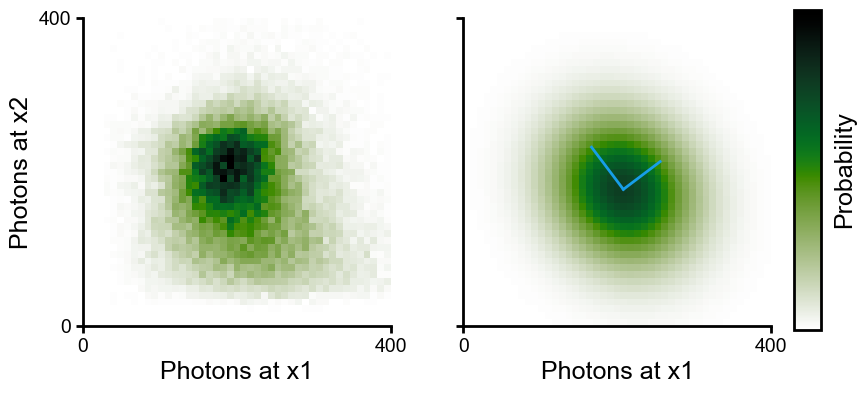

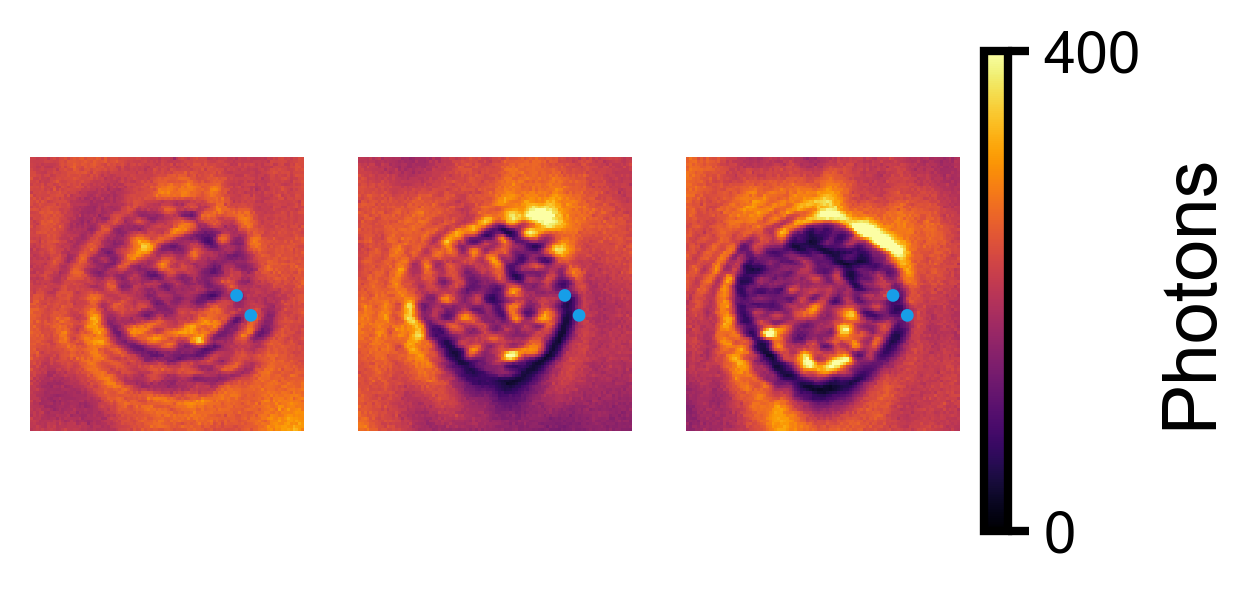

In [15]:
from scipy.stats import multivariate_normal
import cmasher as cmr
import cmocean as cm
from matplotlib.patches import Circle
from matplotlib.cm import ScalarMappable


# for x2_offset_x in tqdm(np.arange(1, 15, 2)): 
# for x_1_offset_x in np.arange(1, 15, 2):
# x2_offset = (x_1_offset_x, x2_offset_x)
# x2_offset = (5, 13)
x2_offset = (7, 5)
# x1_position = (3 * images.shape[1] // 4, 3 * images.shape[2] // 4)
x1_position = (images.shape[1] // 2, 3 * images.shape[2] // 4)


# display_lim = (30, 80)
display_lim = (0, 400)

num_bins = 40
# cmap =  cmr.torch.reversed()
cmap = cmr.jungle.reversed()
# cmap = cm.cm.delta
# cmap = mcolors.LinearSegmentedColormap.from_list(
#     'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
#     cmap(np.linspace(0.5, 1, 256))
# )

color = get_color_cycle()[0]
# cmap = LinearSegmentedColormap.from_list(f'cmap', [(1,1,1), color])


bins = np.linspace(*display_lim, num_bins + 1)


fig_dist, ax_dist = plt.subplots(2, 1, figsize=(5, 8 ), sharex=True, sharey=True)

x1_samples= images[:, x1_position[0], x1_position[1]]
x2_samples = images[:, x1_position[0] + x2_offset[0], x1_position[1] + x2_offset[1]]

# plot a a 2d historgram empirical distribution
p_x, yedges, xedges = np.histogram2d(x2_samples, x1_samples, bins=bins)
p_x /= p_x.sum()

design = np.stack([x1_samples, x2_samples], axis=1)
# compute mean and covariance
mean = np.mean(design, axis=0)
cov = np.cov(design.T)

gaussian_pdf = multivariate_normal.pdf(np.stack(
    np.meshgrid(np.linspace(*display_lim, num_bins), np.linspace(*display_lim, num_bins)), axis=-1),  mean=mean, cov=cov)
gaussian_pdf /= gaussian_pdf.sum()

# compute vmin and vmax for both plots
vmin = onp.min([p_x, gaussian_pdf])
vmax = onp.max([p_x, gaussian_pdf])

# plot a a 2d historgram of the design matrix
ax_dist[0].imshow(p_x, cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
clear_spines(ax_dist[0])
ax_dist[0].set(xticks=display_lim, yticks=display_lim, xlabel='Photons at x1', ylabel='Photons at x2')

# make another plot showing the PDF of the Gaussian
ax_dist[1].imshow(gaussian_pdf, 
    cmap=cmap, origin='lower', extent=[display_lim[0], display_lim[1], display_lim[0], display_lim[1]], vmin=vmin, vmax=vmax)
# draw the major and minor axes of the ellipse
eigvals, eigvecs = np.linalg.eigh(cov)
# plot them
for eigval, eigvec in zip(np.sqrt(eigvals), eigvecs.T):
    ax_dist[1].plot([mean[0], mean[0] +  eigval * eigvec[0]], [mean[1], mean[1] +  eigval * eigvec[1]], color=color, linewidth=2)
# same formatting as before
clear_spines(ax_dist[1])
ax_dist[1].set(xticks=display_lim, yticks=display_lim, xlabel='Photons at x1')

fig_img, ax_img = plt.subplots(1, 3, figsize=(4, 2), dpi=300)
for i in range(3):
    image = images[i]
    ax_img[i].imshow(image, cmap='inferno', interpolation='nearest', vmin=display_lim[0], vmax=display_lim[1])
    ax_img[i].axis('off')
    ax_img[i].add_patch(Circle((x1_position[1], x1_position[0]), 1.5, color=color))
    ax_img[i].add_patch(Circle((x1_position[1] + x2_offset[1], x1_position[0] + x2_offset[0]), 1.5, color=color))
# add a colorbar
fig_img.subplots_adjust(right=0.9)
cbar_ax = fig_img.add_axes([0.92, 0.1, 0.02, 0.8])
sm = ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=display_lim[0], vmax=display_lim[1]))
fig_img.colorbar(sm, cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=display_lim,  ylabel='Photons')
fig_img.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'gaussian_approx' + '.pdf', transparent=True, dpi=600)


# add a colorbar
fig_dist.subplots_adjust(right=0.9)
cbar_ax = fig_dist.add_axes([0.92, 0.1, 0.03, 0.8])
fig_dist.colorbar(ScalarMappable(cmap=cmap), cax=cbar_ax)
# sparse ticks and label "Probability"
cbar_ax.set(yticks=[],  ylabel='Probability')

# fig_dist.suptitle(f'x1 = {x1_position}, x2 = {x1_position} + {x2_offset}')

fig_dist.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'px_gaussian_approx_gaussian' + '.pdf', transparent=True, dpi=600)

